# Training YOLOv8s

In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8s.pt')
results = model.train( data='synthetic_plant_dataset/data.yaml', imgsz=416, epochs=100, patience = 5, batch = -1, name = 'yolov8s', save = True)

### Export in Onnx Format for Jetson Nano

In [ ]:
model.export(format="onnx", opset = 11)

### Load Model Again

In [ ]:
model = YOLO('runs/detect/yolov8s/weights/best.pt')

# Testing Model with Random Image

Loading model from runs/detect/yolov8s/weights/best.pt...
Model loaded successfully.
Scanning for images in: synthetic_plant_dataset/images/val
Randomly selected image: synthetic_003754.jpg
Processing synthetic_003754.jpg: Found 2 GT boxes and 2 Pred boxes.


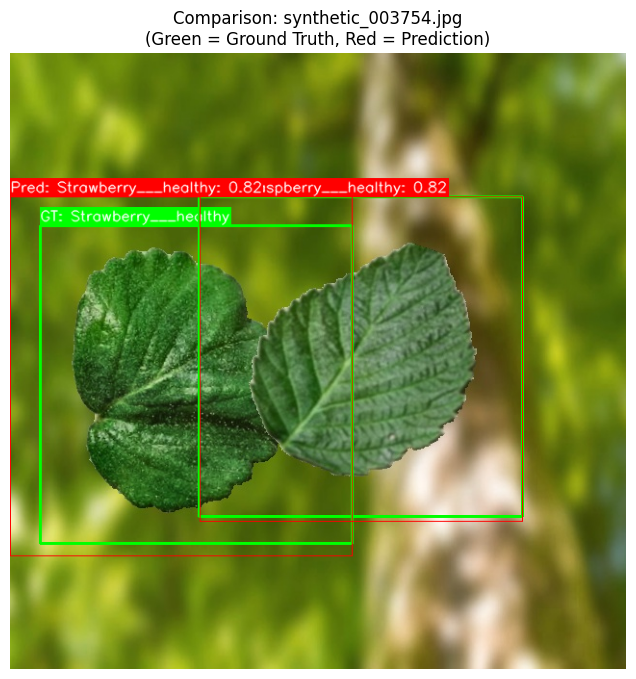


✅ Done! Displayed comparison for synthetic_003754.jpg.


In [7]:
import cv2
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO
import random

# --- 1. CONFIGURATION ---
# --- (!!!) YOU MUST UPDATE THESE PATHS (!!!) ---

# Path to your trained YOLO model file (e.g., best.pt)
MODEL_PATH = "runs/detect/yolov8s/weights/best.pt"

# Path to the directory containing your images (e.g., .../dataset/images/val)
IMAGE_DIR = "synthetic_plant_dataset/images/val"

# Path to the directory containing your ground truth labels (e.g., .../dataset/labels/val)
GT_LABEL_DIR = "synthetic_plant_dataset/labels/val"

# ** IMPORTANT **
# Update this list with your dataset's class names in the correct order.
# The index matches the class ID (e.g., CLASS_NAMES[0] is for class_id 0)
CLASS_NAMES = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy','Cherry_(including_sour)___Powdery_mildew','Cherry_(including_sour)___healthy','Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot','Corn_(maize)___Common_rust_','Corn_(maize)___Northern_Leaf_Blight','Corn_(maize)___healthy','Grape___Black_rot','Grape___Esca_(Black_Measles)','Grape___Leaf_blight_(Isariopsis_Leaf_Spot)','Grape___healthy','Orange___Huanglongbing_(Citrus_greening)','Peach___Bacterial_spot','Peach___healthy','Pepper,_bell___Bacterial_spot','Pepper,_bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Raspberry___healthy','Soybean___healthy','Squash___Powdery_mildew','Strawberry___Leaf_scorch','Strawberry___healthy','Tomato___Bacterial_spot','Tomato___Early_blight','Tomato___Late_blight','Tomato___Leaf_Mold','Tomato___Septoria_leaf_spot','Tomato___Spider_mites Two-spotted_spider_mite','Tomato___Target_Spot','Tomato___Tomato_Yellow_Leaf_Curl_Virus','Tomato___Tomato_mosaic_virus','Tomato___healthy']
# (This is the COCO dataset list, replace it with your own)

# --- 2. STYLING & SETTINGS ---

# Confidence threshold for predictions (e.g., 0.25)
CONF_THRESHOLD = 0.25

# Colors for boxes (in BGR format for OpenCV)
GT_COLOR = (0, 255, 0)   # Green
PRED_COLOR = (0, 0, 255) # Red
TEXT_COLOR = (255, 255, 255) # White

# Box thickness
GT_THICKNESS = 2
PRED_THICKNESS = 1

# --- END OF CONFIGURATION ---

def parse_ground_truth(label_path):
    """
    Reads a YOLO format ground truth label file and returns a list of boxes.
    Each box is a tuple: (class_id, x_center, y_center, width, height, None)
    """
    boxes = []
    if not os.path.exists(label_path):
        return boxes  # Return empty list if no label file

    with open(label_path, 'r') as f:
        for line in f:
            try:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                
                class_id = int(parts[0])
                x_c = float(parts[1])
                y_c = float(parts[2])
                w = float(parts[3])
                h = float(parts[4])
                
                boxes.append((class_id, x_c, y_c, w, h, None)) # Confidence is None
            except Exception as e:
                print(f"Warning: Skipping malformed line in {label_path}: {line.strip()} - Error: {e}")
    return boxes


def parse_predictions(results):
    """
    Parses the results from an Ultralytics YOLO model.
    Returns a list of boxes in the same format:
    (class_id, x_center, y_center, width, height, confidence)
    """
    boxes = []
    if not results or not results[0].boxes:
        return boxes
        
    pred_boxes = results[0].boxes
    
    # Check if a tensor is empty
    if pred_boxes.cls is None or pred_boxes.conf is None or pred_boxes.xywhn is None:
        return boxes

    # Get data as numpy arrays for easier iteration
    classes = pred_boxes.cls.cpu().numpy()
    confidences = pred_boxes.conf.cpu().numpy()
    xywhn_boxes = pred_boxes.xywhn.cpu().numpy()

    for i in range(len(classes)):
        class_id = int(classes[i])
        confidence = confidences[i]
        
        x_c, y_c, w, h = xywhn_boxes[i]
        
        boxes.append((class_id, x_c, y_c, w, h, confidence))
        
    return boxes


def draw_box(image, box_data, color, thickness, label_prefix=""):
    """
    Draws a single bounding box and label on the image.
    """
    img_h, img_w = image.shape[:2]
    
    class_id, x_c, y_c, w, h, confidence = box_data
    
    # 1. Convert normalized YOLO coords to absolute pixel coords
    abs_x_c = x_c * img_w
    abs_y_c = y_c * img_h
    abs_w = w * img_w
    abs_h = h * img_h
    
    # 2. Calculate top-left (x1, y1) and bottom-right (x2, y2)
    x1 = int(abs_x_c - (abs_w / 2))
    y1 = int(abs_y_c - (abs_h / 2))
    x2 = int(abs_x_c + (abs_w / 2))
    y2 = int(abs_y_c + (abs_h / 2))
    
    # 3. Draw the bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)
    
    # 4. Prepare the label text
    try:
        label = CLASS_NAMES[class_id]
    except IndexError:
        label = f"Class_{class_id}"
        
    display_text = f"{label_prefix}{label}"
    if confidence is not None:
        display_text += f": {confidence:.2f}"
        
    # 5. Add text label with a filled background for visibility
    (text_w, text_h), baseline = cv2.getTextSize(display_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    cv2.rectangle(image, (x1, y1 - text_h - baseline - 2), (x1 + text_w, y1), color, -1)
    cv2.putText(image, display_text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, TEXT_COLOR, 1, cv2.LINE_AA)


def main():
    # 1. Load the YOLO model
    print(f"Loading model from {MODEL_PATH}...")
    try:
        model = YOLO(MODEL_PATH)
    except Exception as e:
        print(f"Error loading model. Make sure 'ultralytics' is installed and path is correct.")
        print(f"Error: {e}")
        return
    print("Model loaded successfully.")
    
    # 2. Find all image files
    print(f"Scanning for images in: {IMAGE_DIR}")
    try:
        image_files = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    except FileNotFoundError:
        print(f"Error: IMAGE_DIR not found at '{IMAGE_DIR}'. Please check your configuration.")
        return
        
    if not image_files:
        print("No images found. Exiting.")
        return
        
    # --- MODIFICATION ---
    # 3. Select one random image from the list
    image_name = random.choice(image_files)
    print(f"Randomly selected image: {image_name}")
    # --- END MODIFICATION ---

    # 4. Process the single selected image
    image_path = os.path.join(IMAGE_DIR, image_name)
    
    # Get the base filename (e.g., "image1" from "image1.jpg")
    base_name = os.path.splitext(image_name)[0]
    
    # Construct path for ground truth label file
    gt_label_path = os.path.join(GT_LABEL_DIR, base_name + '.txt')
    
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image {image_path}. Exiting.")
        return
        
    # --- PREDICTION ---
    results = model(image_path, conf=CONF_THRESHOLD, verbose=False)
    
    # --- PARSING ---
    gt_boxes = parse_ground_truth(gt_label_path)
    pred_boxes = parse_predictions(results)
    
    print(f"Processing {image_name}: Found {len(gt_boxes)} GT boxes and {len(pred_boxes)} Pred boxes.")
    
    # --- DRAWING ---
    # Draw Ground Truth boxes (Green, Thicker)
    for box in gt_boxes:
        draw_box(image, box, GT_COLOR, GT_THICKNESS, label_prefix="GT: ")
        
    # Draw Prediction boxes (Red, Thinner)
    for box in pred_boxes:
        draw_box(image, box, PRED_COLOR, PRED_THICKNESS, label_prefix="Pred: ")
        
    # --- DISPLAY ---
    # Convert the image from BGR (OpenCV's default) to RGB (Matplotlib's default)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    plt.title(f"Comparison: {image_name}\n(Green = Ground Truth, Red = Prediction)")
    plt.axis('off')
    plt.show() # Display the image.

    print(f"\n✅ Done! Displayed comparison for {image_name}.")


if __name__ == "__main__":
    main()